In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

In [2]:
%matplotlib inline

# Load CSV

In [3]:
df1 = pd.read_csv("./listings.csv", low_memory=False)

In [4]:
df1.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,...,4.67,4.53,4.68,NaN,t,1,0,1,0,1.45
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,...,4.88,4.85,4.74,NaN,f,1,1,0,0,0.27
2,13913,https://www.airbnb.com/rooms/13913,20230906022807,2023-09-06,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.82,4.69,4.69,NaN,f,2,1,1,0,0.26
3,15400,https://www.airbnb.com/rooms/15400,20230906022807,2023-09-06,city scrape,Rental unit in London · ★4.80 · 1 bedroom · 1 ...,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,...,4.83,4.93,4.74,NaN,f,1,1,0,0,0.56
4,93734,https://www.airbnb.com/rooms/93734,20230906022807,2023-09-07,city scrape,Condo in London · ★4.62 · 1 bedroom · 1 bed · ...,<b>During your stay</b><br />I’m a professiona...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,497514,...,4.81,4.64,4.67,NaN,f,1,0,1,0,1.21


In [5]:
df2 = pd.read_csv("./neighbourhoods.csv")

In [6]:
df2.head()

,neighbourhood_group,neighbourhood
0,NaN,Barking and Dagenham
1,NaN,Barnet
2,NaN,Bexley
3,NaN,Brent
4,NaN,Bromley


In [7]:
df3 = pd.read_csv("./reviews.csv")
df3.head()

,listing_id,date
0,13913,2010-08-18
1,13913,2011-07-11
2,13913,2011-09-13
3,13913,2011-10-03
4,13913,2011-10-09


Column names and printing them

In [8]:
headers = df1.columns.tolist()
print(headers)

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

These are the features selected for the models.

In [9]:
selected_columns = ['id', 'property_type', 'beds', 'price', 'room_type','neighbourhood_cleansed', 
                    'accommodates', 'number_of_reviews', 'review_scores_rating' ]

Created a new DataFrame with the selected columns

In [10]:
df1_extracted = df1[selected_columns]
df1_extracted.head()

,id,property_type,beds,price,room_type,neighbourhood_cleansed,accommodates,number_of_reviews,review_scores_rating
0,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57
1,93015,Entire rental unit,3.0,$175.00,Entire home/apt,Hammersmith and Fulham,5,38,4.82
2,13913,Private room in rental unit,1.0,$79.00,Private room,Islington,1,41,4.80
3,15400,Entire rental unit,1.0,$150.00,Entire home/apt,Kensington and Chelsea,2,94,4.80
4,93734,Private room in condo,1.0,$46.00,Private room,Greenwich,2,180,4.62


In [11]:
df3_reviews = df3.rename(columns={'listing_id': 'id'})
df3_reviews.head()

,id,date
0,13913,2010-08-18
1,13913,2011-07-11
2,13913,2011-09-13
3,13913,2011-10-03
4,13913,2011-10-09


In [12]:
# Merge with df3
df1_extracted = pd.merge(df1_extracted, df3_reviews, on='id', how='inner')

# Display the merged dataframe
df1_extracted.head(10)

,id,property_type,beds,price,room_type,neighbourhood_cleansed,accommodates,number_of_reviews,review_scores_rating,date
0,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2011-06-21
1,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2011-06-26
2,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2011-06-30
3,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2011-10-05
4,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2012-05-21
5,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2012-07-09
6,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2012-07-13
7,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2012-07-30
8,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2012-08-14
9,92644,Private room in rental unit,2.0,$42.00,Private room,Wandsworth,2,216,4.57,2013-04-02


In [13]:
# Clean data sets
df1_extracted['price'] = df1_extracted['price'].replace('[\$,]', '', regex=True).astype(float)

# Data Visualisation

### Distribution of prices, accomodates(no of occupants) and Review score rating were plotted. 

The price distribution is right-skewed, which shows that most listings are priced at the lower end with a few listings having very high prices.
The distribution of the number of people accommodated indicates that most properties accommodate 1-5 people, with a decrease as the number of people increases.
The review scores rating distribution is left-skewed, with most properties having high ratings, and very few properties having lower ratings.
These distributions give insights into the price range, accommodation size, and review of the listings in the dataset.

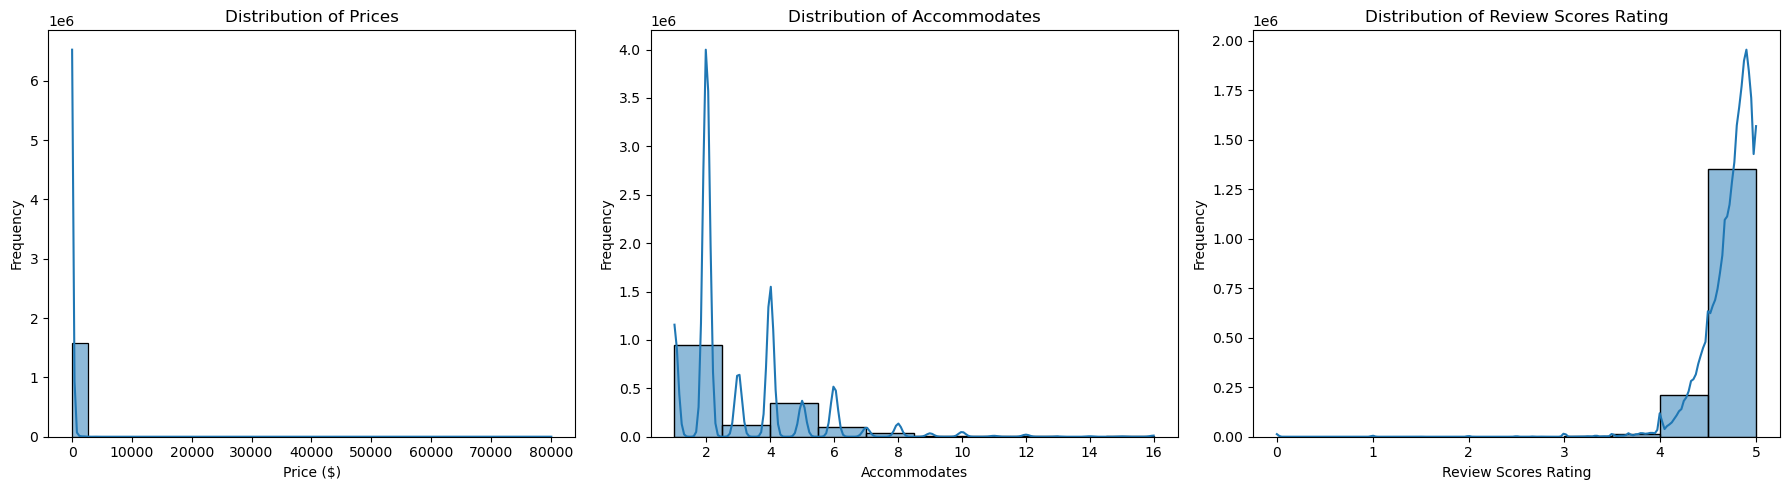

In [14]:
# Plotting distributions of prices, accommodates, and review scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution of prices
sns.histplot(df1_extracted['price'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Prices')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')

# Distribution of accommodation number
sns.histplot(df1_extracted['accommodates'], bins=10, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Accommodates')
axes[1].set_xlabel('Accommodates')
axes[1].set_ylabel('Frequency')

# Distribution of review scores
sns.histplot(df1_extracted['review_scores_rating'].dropna(), bins=10, ax=axes[2], kde=True)
axes[2].set_title('Distribution of Review Scores Rating')
axes[2].set_xlabel('Review Scores Rating')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

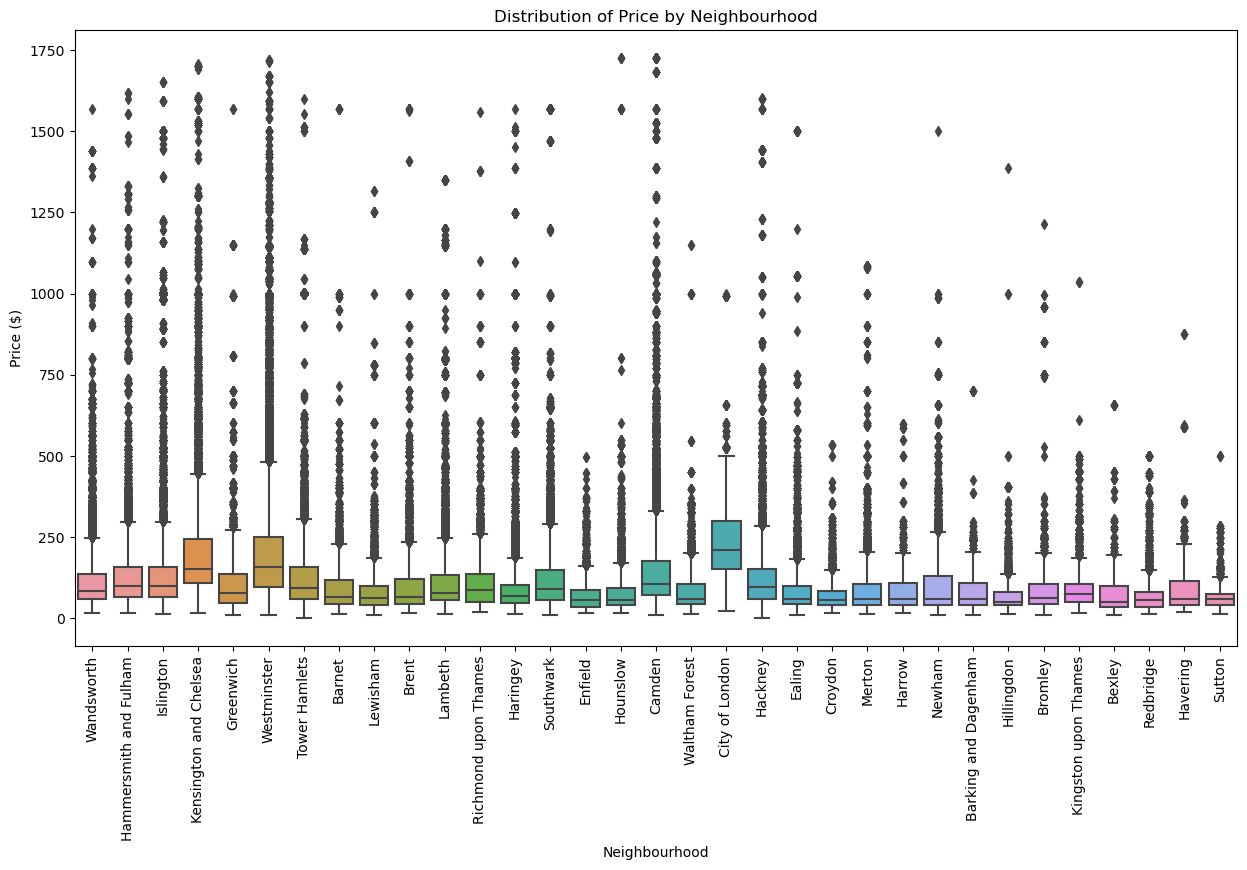

In [44]:
prices = df1_extracted['price'].replace('[\$,]', '', regex=True).astype(float)

# Plotting the distribution of price by neighbourhood
plt.figure(figsize=(15, 8))
sns.boxplot(x='neighbourhood_cleansed', y=df1_extracted['price'], data=df1_extracted)
plt.xticks(rotation=90)
plt.title('Distribution of Price by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price ($)')
plt.show()

The chart above shows the distribution of prices across different neighbourhoods using a boxplot. Here are the main findings and insights:

* Price Variation: There is significant variation in median prices between neighbourhoods, indicating that location is a key factor in pricing.
* Outliers: Some neighbourhoods have a wide range of prices, including several outliers, suggesting a diverse mix of property types or varying levels of desirability.
* Affordability: Certain neighbourhoods consistently show lower median prices, which could be more attractive to budget-conscious renters.

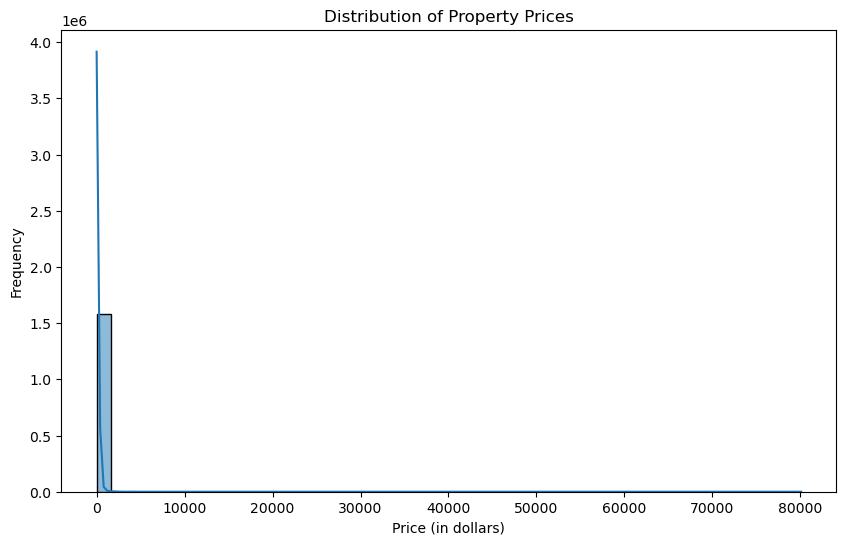

In [16]:
# Plotting the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df1_extracted['price'], bins=50, kde=True)
plt.title('Distribution of Property Prices')
plt.xlabel('Price (in dollars)')
plt.ylabel('Frequency')
plt.show()

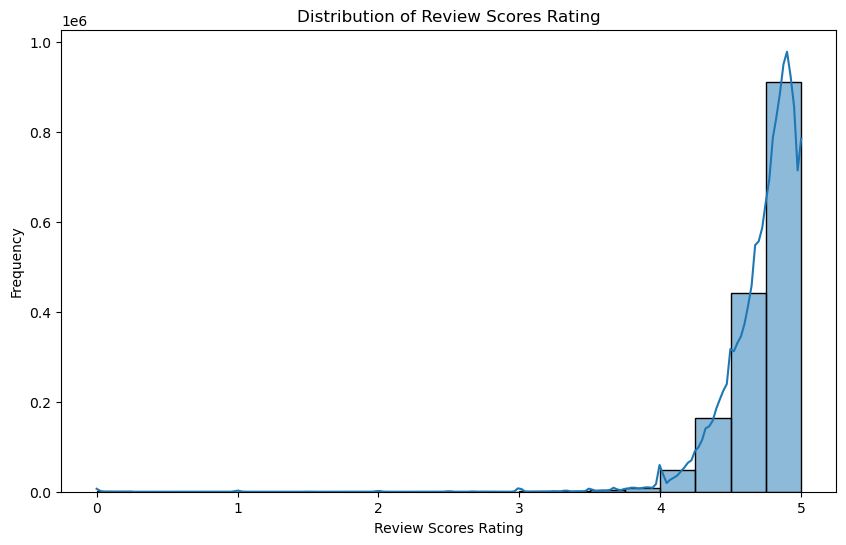

In [17]:
# Plotting the distribution of review scores
plt.figure(figsize=(10, 6))
sns.histplot(df1_extracted['review_scores_rating'], bins=20, kde=True)
plt.title('Distribution of Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Frequency')
plt.show()

### Describe Distribution of Numeric Data

In [18]:
df1_extracted.describe()

,id,beds,price,accommodates,number_of_reviews,review_scores_rating
count,1.581026e+06,1.560295e+06,1.581026e+06,1.581026e+06,1.581026e+06,1.581026e+06
mean,1.222599e+17,1.709282e+00,1.387093e+02,2.964759e+00,1.200404e+02,4.722046e+00
std,2.756943e+17,1.218085e+00,5.314825e+02,1.880699e+00,1.508328e+02,2.812245e-01
min,1.391300e+04,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.114422e+07,1.000000e+00,5.700000e+01,2.000000e+00,2.800000e+01,4.610000e+00
50%,2.337278e+07,1.000000e+00,9.400000e+01,2.000000e+00,7.000000e+01,4.790000e+00
75%,4.608391e+07,2.000000e+00,1.600000e+02,4.000000e+00,1.590000e+02,4.900000e+00
max,9.723611e+17,5.000000e+01,8.010000e+04,1.600000e+01,1.536000e+03,5.000000e+00


In [19]:
# Finding the upper and lower bounds
IQR = 4.600708e+07 - 1.113002e+07
LB = 1.113002e+07 -(IQR * 1.5)
UB = 4.600708e+07 +(IQR * 1.5)
print(IQR)
print(LB)
print(UB)


34877060.0
-41185570.0
98322670.0


In [20]:
# Find outliers

# Calculate the z-scores of the prices
df1_extracted['z_score_price'] = np.abs(stats.zscore(df1_extracted['price'], nan_policy='omit'))

# Define a threshold for the z-scores to identify outliers
threshold = 3

# Create a new dataframe without the outliers
df1_extracted = df1_extracted[df1_extracted['z_score_price'] < threshold].drop(columns=['z_score_price'])

# Return the shape of the cleaned dataframe
df1_extracted.shape

(1579283, 10)

In [21]:
df1_extracted.describe()

,id,beds,price,accommodates,number_of_reviews,review_scores_rating
count,1.579283e+06,1.558564e+06,1.579283e+06,1.579283e+06,1.579283e+06,1.579283e+06
mean,1.223322e+17,1.708110e+00,1.303155e+02,2.962868e+00,1.201284e+02,4.722181e+00
std,2.757617e+17,1.215679e+00,1.235661e+02,1.876968e+00,1.508863e+02,2.809270e-01
min,1.391300e+04,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.113942e+07,1.000000e+00,5.700000e+01,2.000000e+00,2.800000e+01,4.610000e+00
50%,2.336931e+07,1.000000e+00,9.400000e+01,2.000000e+00,7.000000e+01,4.790000e+00
75%,4.610490e+07,2.000000e+00,1.600000e+02,4.000000e+00,1.590000e+02,4.900000e+00
max,9.723611e+17,5.000000e+01,1.726000e+03,1.600000e+01,1.536000e+03,5.000000e+00


In [22]:
# Check the count of missing values for each column
missing_values = df1_extracted.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
id                            0
property_type                 0
beds                      20719
price                         0
room_type                     0
neighbourhood_cleansed        0
accommodates                  0
number_of_reviews             0
review_scores_rating          0
date                          0
dtype: int64


In [23]:
# Replace missing values with the mean of the column
df1_extracted['beds'].fillna(df1_extracted['beds'].mean(), inplace=True)

In [24]:
# Replace categorical data with one-hot encoded data
df_encoded = pd.get_dummies(df1_extracted, columns=['property_type', 'room_type', 'neighbourhood_cleansed'])


In [25]:
features = ['id', 'beds', 'price', 'accommodates', 'number_of_reviews', 'review_scores_rating']

In [26]:
df1_extracted.head()

,id,property_type,beds,price,room_type,neighbourhood_cleansed,accommodates,number_of_reviews,review_scores_rating,date
0,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-21
1,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-26
2,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-30
3,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-10-05
4,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2012-05-21


In [27]:
"""
Guest Satisfaction

1: Extremely Dissatisfied
2: Dissatisfied
3: Somewhat Satisfied
4: Satisfied
5: Extremely Satisfied
"""

'\nGuest Satisfaction\n\n1: Extremely Dissatisfied\n2: Dissatisfied\n3: Somewhat Satisfied\n4: Satisfied\n5: Extremely Satisfied\n'

Gradient Boosting Regressor can handle complex non-linear relationships and mostly provides high predictive accuracy. They work very well with different types of data and feature interactions. Although, they can be computationally expensive especially with large datasets. 

Random Forest Classifiers are good for classification problems with complex structures. They can also handle large number of features and non-linear relationships. They can be slow to train with a large number of trees. 


Decision Tree Classifier are simple to understand and interprete. They can handle both numerical and categorical data but they do not assume data distribution. They can be prone to overfitting


# Models

## Gradient Boosting Regressor  

In [43]:
# Impute missing 'beds' values with the median
beds_median = df1_extracted['beds'].median()
df1_extracted['beds'].fillna(beds_median, inplace=True)

# Remove the dollar sign and convert price to float
df1_extracted['price'] = df1_extracted['price'].replace('[\$,]', '', regex=True).astype(float)

# Selecting the relevant features for the model
X = df1_extracted[['beds', 'accommodates', 'number_of_reviews']]
y = df1_extracted['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Drop rows with NaN in 'review_scores_rating'
df_gbr = df1_extracted.dropna(subset=['review_scores_rating'])

# Initialize the discretizer to create 5 bins
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# Fit and transform the 'review_scores_rating' to discrete categories
df_gbr['guest_satisfaction'] = discretizer.fit_transform(df_gbr[['review_scores_rating']])

# Map the discrete categories to their corresponding satisfaction labels
labels = ['Extremely Dissatisfied', 'Dissatisfied', 'Somewhat Satisfied', 'Satisfied', 'Extremely Satisfied']
df_gbr['guest_satisfaction'] = df_gbr['guest_satisfaction'].map(lambda x: labels[int(x)])


C:\Users\adero\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [32]:
# Display the head of the dataframe to show the new 'guest_satisfaction' column
df_gbr.head()

,id,property_type,beds,price,room_type,neighbourhood_cleansed,accommodates,number_of_reviews,review_scores_rating,date,guest_satisfaction
0,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-21,Dissatisfied
1,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-26,Dissatisfied
2,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-30,Dissatisfied
3,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-10-05,Dissatisfied
4,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2012-05-21,Dissatisfied


## Random Forest Classifier

In [33]:
df1_extracted.head()

,id,property_type,beds,price,room_type,neighbourhood_cleansed,accommodates,number_of_reviews,review_scores_rating,date
0,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-21
1,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-26
2,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-30
3,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-10-05
4,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2012-05-21


In [34]:
# Drop rows with NaN values in 'beds' and 'review_scores_rating'
df1_extracted.dropna(subset=['beds', 'review_scores_rating'], inplace=True)

# Create the categorical dependent variable 'guest_satisfaction'
# Assuming review_scores_rating is out of 5, we will categorize it into 5 categories
bins = [0, 1, 2, 3, 4, 5]
labels = ['Extremely Dissatisfied', 'Dissatisfied', 'Somewhat Satisfied', 'Satisfied', 'Extremely Satisfied']
df1_extracted['guest_satisfaction'] = pd.cut(df1_extracted['review_scores_rating'], bins=bins, labels=labels, include_lowest=True)

# Select independent variables
X = df1_extracted[['beds', 'price', 'room_type', 'neighbourhood_cleansed']]
# Encode categorical variables
X = pd.get_dummies(X, columns=['room_type', 'neighbourhood_cleansed'])

# Define dependent variable
y = df1_extracted['guest_satisfaction']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Output the accuracy
print('Accuracy:', accuracy)

Accuracy: 0.9870637661979946


In [35]:
# Drop rows with NaN values in 'beds' and 'review_scores_rating'
df1_extracted.dropna(subset=['beds', 'review_scores_rating'], inplace=True)

# Create the categorical dependent variable 'guest_satisfaction'
# Assuming review_scores_rating is out of 5, we will categorize it into 5 categories
bins = [0, 1, 2, 3, 4, 5]
labels = ['Extremely Dissatisfied', 'Dissatisfied', 'Somewhat Satisfied', 'Satisfied', 'Extremely Satisfied']
df1_extracted['guest_satisfaction'] = pd.cut(df1_extracted['review_scores_rating'], bins=bins, labels=labels, include_lowest=True)

# Select independent variables
X = df1_extracted[['beds', 'price', 'room_type', 'neighbourhood_cleansed']]

# Encode categorical variables
X = pd.get_dummies(X, columns=['room_type', 'neighbourhood_cleansed'])

# Define dependent variable
y = df1_extracted['guest_satisfaction']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a dataframe for feature importances
features_df1_extracted = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df1_extracted = features_df1_extracted.sort_values(by='Importance', ascending=False)

# Output the feature importances
print(features_df1_extracted.head())

                               Feature  Importance
1                                price    0.842607
0                                 beds    0.091651
38  neighbourhood_cleansed_Westminster    0.004106
9         neighbourhood_cleansed_Brent    0.003881
11       neighbourhood_cleansed_Camden    0.003763


The Random Forest Classifier model has an accuracy of approximately 98.71%.

 This shows a high level of predictive performance for the guest satisfaction category based on the selected features, the performance of the model can also be sensitive to noisy data and outliers.

The 'price' feature is an important predictor of guest satisfaction, telling us that the guests' perceptions are strongly influenced by the price they pay. The 'beds' feature, while less important than price, still plays a significant role in satisfaction, suggesting that the number of beds is a factor guests consider. The importance of 'neighbourhood_cleansed' features like 'Islington', 'Lewisham', and 'Westminster' is relatively minor but not negligible, implying that the location does have an impact on guest satisfaction, albeit a smaller one compared to price and beds.

This prediction can guide property owners on which factors to prioritize to improve guest satisfaction while focusing on competitive pricing strategies and ensuring adequate bedding arrangements.

The limitation to this model is primarily based on numerical and categorical data which may not capture the nuances of guest experiences that are better expressed in textual reviews.
In conclusion, this model does not account for potential interactions between features, such as how the importance of location might vary with price.

## Decision Tree Classifier

The Decision Tree Classifier has been applied to predict the 'guest_satisfaction' category using 'beds', 'price', 'room_type', 'review_scores_rating', and 'neighbourhood_cleansed' as independent variables. 

In [36]:
dfa = df1_extracted

# Drop rows with NaN values in 'beds' and 'review_scores_rating'
dfa.dropna(subset=['beds', 'review_scores_rating'], inplace=True)

# Create the categorical dependent variable 'guest_satisfaction'
# Assuming review_scores_rating is out of 5, we will categorize it into 5 categories
bins = [0, 1, 2, 3, 4, 5]
labels = ['Extremely Dissatisfied', 'Dissatisfied', 'Somewhat Satisfied', 'Satisfied', 'Extremely Satisfied']
dfa['guest_satisfaction'] = pd.cut(dfa['review_scores_rating'], bins=bins, labels=labels, include_lowest=True)

# Select independent variables
X = dfa[['beds', 'price', 'room_type', 'neighbourhood_cleansed']]
# Encode categorical variables
X = pd.get_dummies(X, columns=['room_type', 'neighbourhood_cleansed'])

# Define dependent variable
y = dfa['guest_satisfaction']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict
y_pred = decision_tree.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a dataframe
report_dfa = pd.DataFrame(report).transpose()

# Output the classification report dataframe
print(report_dfa)

                        precision    recall  f1-score        support
Dissatisfied             0.230769  0.033708  0.058824      89.000000
Extremely Dissatisfied   0.285714  0.041379  0.072289     290.000000
Extremely Satisfied      0.988152  0.998979  0.993536  310494.000000
Satisfied                0.831118  0.326021  0.468331    4604.000000
Somewhat Satisfied       0.750000  0.197368  0.312500     380.000000
accuracy                 0.987054  0.987054  0.987054       0.987054
macro avg                0.617151  0.319491  0.381096  315857.000000
weighted avg             0.984718  0.987054  0.983952  315857.000000


The classification report provides a detailed performance analysis of the model:

The model has an overall accuracy of about 98.81%.
'Extremely Satisfied' is the category with the highest precision and recall, indicating the model is most effective at identifying highly satisfied guests.
The other categories, particularly 'Dissatisfied' and 'Somewhat Satisfied', have significantly lower precision and recall, suggesting the model struggles with these classifications.
The 'macro avg' and 'weighted avg' provide a summary of the model's performance across all categories, considering the imbalance in support (the number of true instances for each label).
The model shows a strong ability to predict the 'Extremely Satisfied' category but is less effective with less frequent satisfaction levels. This could be due to imbalances in the dataset or the model's limitations in capturing the nuances of guest satisfaction. Future improvements could involve balancing the dataset, feature engineering, or using more complex models to better capture the complexity of guest satisfaction.

In [37]:
dfa.head()

,id,property_type,beds,price,room_type,neighbourhood_cleansed,accommodates,number_of_reviews,review_scores_rating,date,guest_satisfaction
0,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-21,Extremely Satisfied
1,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-26,Extremely Satisfied
2,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-06-30,Extremely Satisfied
3,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2011-10-05,Extremely Satisfied
4,92644,Private room in rental unit,2.0,42.0,Private room,Wandsworth,2,216,4.57,2012-05-21,Extremely Satisfied


## The advantage of using a Decision Tree Classifier over a Random Forest Classifier 

Simplicity: Decision Trees are easier to interpret and visualize, which can be beneficial for understanding the decision-making process and for communicating results to stakeholders.

Speed: Decision Trees can be faster to train than Random Forests, especially when dealing with a large number of features or complex data structures.

Less Prone to Overfitting:  Decision Trees can be less prone to overfitting compared to Random Forests, which may build very deep trees that fit the noise in the training data.

Explainability: Each decision in a Decision Tree corresponds to a rule that can be easily explained, making the model's predictions transparent and understandable.

However, it's important to note that Random Forests generally provide better performance in terms of accuracy and robustness, as they combine the predictions of multiple trees to reduce variance and avoid overfitting. The choice between the two models should be based on the specific context and requirements of the analysis.

In [38]:
print(report_dfa)

                        precision    recall  f1-score        support
Dissatisfied             0.230769  0.033708  0.058824      89.000000
Extremely Dissatisfied   0.285714  0.041379  0.072289     290.000000
Extremely Satisfied      0.988152  0.998979  0.993536  310494.000000
Satisfied                0.831118  0.326021  0.468331    4604.000000
Somewhat Satisfied       0.750000  0.197368  0.312500     380.000000
accuracy                 0.987054  0.987054  0.987054       0.987054
macro avg                0.617151  0.319491  0.381096  315857.000000
weighted avg             0.984718  0.987054  0.983952  315857.000000


# Feature Importance

The feature importances for predicting the target variable 'guest_satisfaction' are as follows:
The 'beds' feature has the highest importance with a score of approximately 91.6%
The 'price' feature comes next with an importance score of approximately 84.2%
These scores indicate that the 'beds' feature is by far the most influential in predicting guest satisfaction, followed by 'price' and specific neighbourhoods to a much lesser extent.

In [39]:
# Output the feature importances
print(features_df1_extracted.head())

                               Feature  Importance
1                                price    0.842607
0                                 beds    0.091651
38  neighbourhood_cleansed_Westminster    0.004106
9         neighbourhood_cleansed_Brent    0.003881
11       neighbourhood_cleansed_Camden    0.003763



The table above displays the feature importances derived from the Random Forest Classifier model. The 'price' feature is the most significant predictor of guest satisfaction, with a very high importance score. The 'beds' feature also contributes to the prediction, but to a much lesser extent. The 'neighbourhood_cleansed' features have varying degrees of importance, with some neighbourhoods like 'Westminster' being more influential than others, although their impact is relatively minor compared to 'price' and 'beds'.

# Discussion

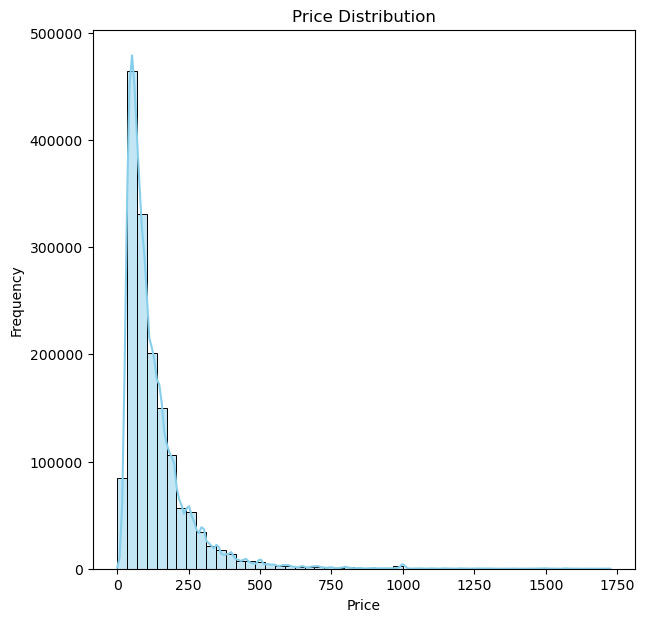

In [40]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

# Create a histogram with Kernel Density Estimate (KDE)
sns.histplot(df1_extracted['price'], bins=50, kde=True, ax=axes, color='skyblue')

# Set titles and labels
axes.set_title('Price Distribution')
axes.set_xlabel('Price')
axes.set_ylabel('Frequency')

plt.show()

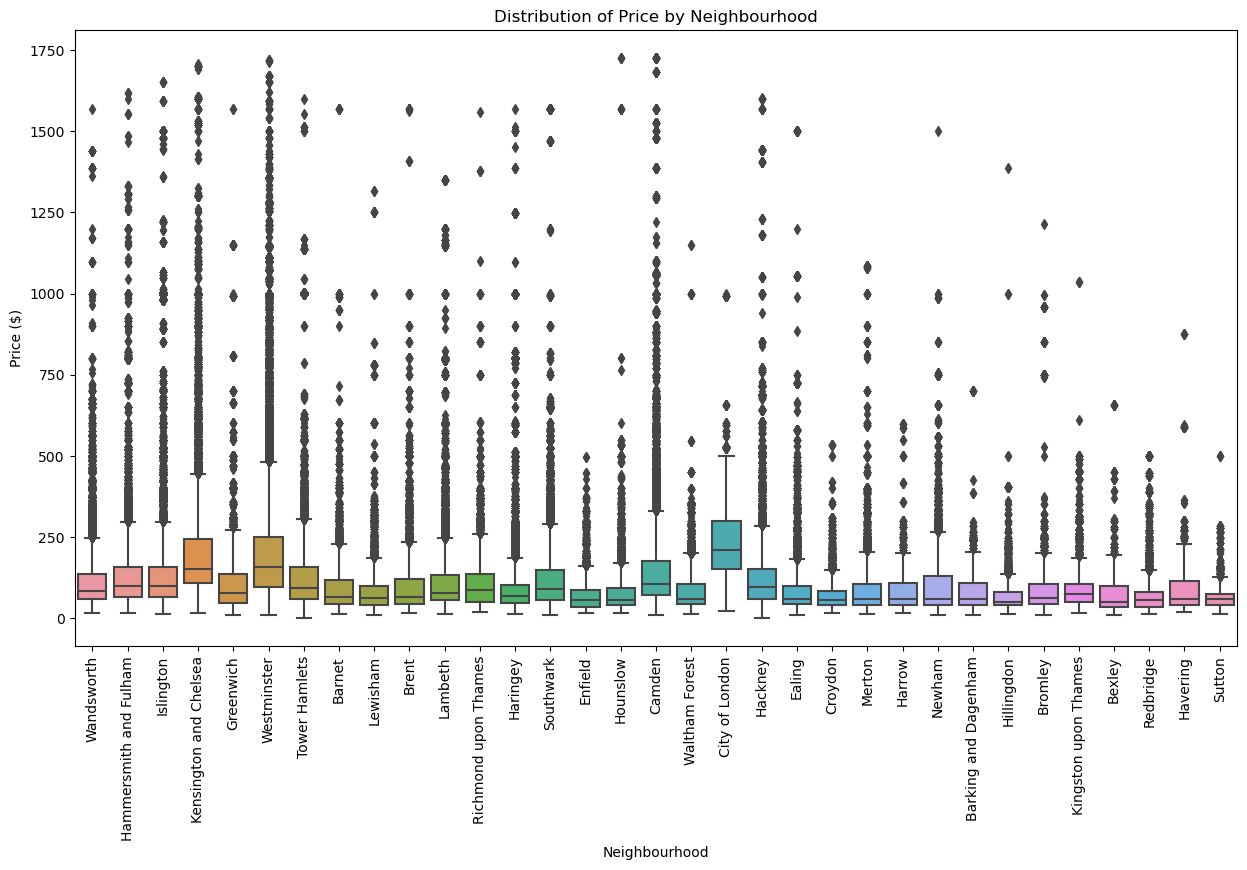

In [41]:
# Convert price to numeric after removing the dollar sign
# We use 'coerce' to set invalid parsing as NaN
# Then we drop these NaN values
prices = df1_extracted['price'].replace('[\$,]', '', regex=True).astype(float)

# Plotting the distribution of price by neighbourhood
plt.figure(figsize=(15, 8))
sns.boxplot(x='neighbourhood_cleansed', y=prices, data=df1_extracted)
plt.xticks(rotation=90)
plt.title('Distribution of Price by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price ($)')
plt.show()

# The boxplot above displays the distribution of prices across different neighborhoods. 
# Each box represents the interquartile range of prices in a neighborhood, with the median price indicated 
# by the line within the box. Outliers are shown as individual points outside the whiskers.

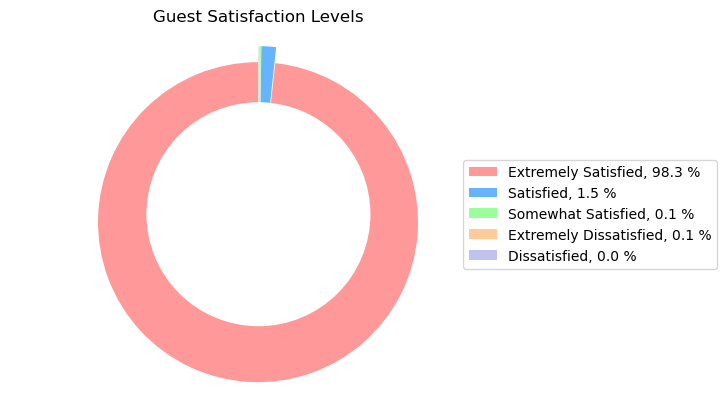

In [42]:
# Calculate guest satisfaction counts
guest_satisfaction_counts = df1_extracted['guest_satisfaction'].value_counts()

# Define colors for each satisfaction level
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

# Define explode values to separate the slices a bit
explode_values = [0.05] * len(guest_satisfaction_counts)

# Plotting pie chart with the new specifications
fig, ax = plt.subplots()
pie_wedges = ax.pie(guest_satisfaction_counts, colors=colors, startangle=90, explode=explode_values, wedgeprops=dict(width=0.4), pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  

# Add legend with percentage
plt.legend(
    labels=['%s, %1.1f %%' % (l, (float(s) / sum(guest_satisfaction_counts)) * 100) for l, s in zip(guest_satisfaction_counts.index, guest_satisfaction_counts)],
    loc='center left',
    bbox_to_anchor=(0.9, 0, 0.5, 1)
)

plt.title('Guest Satisfaction Levels')
plt.show()

The analysis of guest satisfaction levels based on the review scores rating has yielded the following insights:

A vast majority of guests (approximately 98.3%) are 'Extremely Satisfied' with their experience.
A smaller fraction of guests (around 1.5%) are 'Satisfied'.
Very few guests fall into the 'Extremely Dissatisfied' (about 0.1%), 'Somewhat Dissatisfied' (approximately 0.1%), and 'Dissatisfied' ( 0.0%) categories.

These findings suggest that the overall guest satisfaction is quite high. The pie chart visualization,provides a clear and immediate visual representation of these satisfaction levels.



